In [1]:
%matplotlib inline
import warnings
import math
from skimage.util.shape import view_as_windows
from skimage.io import imread, imshow, imsave
from skimage import img_as_float, img_as_ubyte
from scipy.fftpack import dct, idct
import math

import numpy as np
warnings.filterwarnings('ignore')

(562, 750, 3)


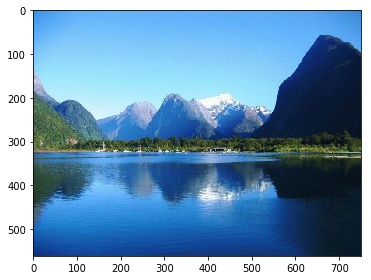

In [2]:
img = imread('img.jpg')
print(img.shape)
imshow(img)

In [3]:
# YCbCr -> rgb
def YCbCr_to_rgb(img):
    img = img.astype('float')
    img[:, :, 1] -= 128
    img[:, :, 2] -= 128
    coeffs = [[1, 0, 1.402], [1, -0.34414, -0.71414], [1, 1.772, 0]]
    new_img = np.dot(img, np.transpose(coeffs))
    new_img = np.clip(new_img, 0, 255)
    return new_img.astype('uint8')


# Децимация
def decim(u):
    x, y = u.shape[0] // 2, u.shape[1] // 2
    t = view_as_windows(u, (2,2), step=2)
    temp = [[]]
    k = 0
    for elem in t:
        for i in elem:
            if k < y:
                temp[-1].append(int(i.mean()))
                k += 1
            else:
                k = 1
                temp.append([])
                temp[-1].append(int(i.mean()))
    #new = np.array(np.repeat(np.repeat(temp, 2, axis=1), 2, axis=0))
    return np.array(temp)

def recovery(u, new):
    if u.shape[1] % 2 != 0 and u.shape[0] % 2 == 0:
        new = np.hstack((new, np.reshape(u[:, -1], (-1, 1))))
    if u.shape[1] % 2 == 0 and u.shape[0] % 2 != 0:
        new = np.vstack((new, np.reshape(u[-1, :], (1, -1))))
    if u.shape[1] % 2 != 0 and u.shape[0] % 2 != 0:
        new = np.vstack((new, np.reshape(u[-1, :], (1, -1))[-1][:-1]))
        new = np.hstack((new, np.reshape(u[:, -1], (-1, 1))))
    return new

# rgb -> yuv
def rgb_to_YCbCr(img):
    coeffs = [[0.299, 0.587, 0.114], [-0.1687, -0.3313, 0.5], [0.5, -0.4187, -0.0813]]
    new_img = np.dot(img, np.transpose(coeffs))
    new_img[:, :, 1] += 128
    new_img[:, :, 2] += 128
    return new_img.astype('uint8')

In [4]:
# Дополнение изображение до кратности 16 (Учитываем, что при децимации мы делим еще на 2)
def refect_across_edge(img, a):
    new_img = img.copy()
    height, width = img.shape[0] % a, img.shape[1] % a
    if width != 0:
        if width % 2 == 0:
            k = (a - width) // 2
            new_img = np.hstack((new_img, np.flip(new_img[:, -k:], 1)))
            new_img = np.hstack((np.flip(new_img[:, :k], 1), new_img))
        else:
            k = (a - width) // 2
            new_img = np.hstack((new_img, np.flip(new_img[:, -(k+1):], 1)))
            new_img = np.hstack((np.flip(new_img[:, :k], 1), new_img))
    if height != 0:
        if height % 2 == 0:
            k = (a - height) // 2
            new_img = np.vstack((new_img, np.flip(new_img[-k:, :], 0)))
            new_img = np.vstack((np.flip(new_img[:k, :], 0), new_img))
        else:
            k = (a - height) // 2
            new_img = np.vstack((new_img, np.flip(new_img[-(k+1):, :], 0)))
            new_img = np.vstack((np.flip(new_img[:k, :], 0), new_img))
    return new_img

In [5]:
lum = np.array([
                [16, 11, 10, 16, 24, 40, 51, 61],
                [12, 12, 14, 19, 26, 58, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99],
                ])

chrom = np.array([
                [17, 18, 24, 47, 99, 99, 99, 99],
                [18, 21, 26, 66, 99, 99, 99, 99],
                [24, 26, 56, 99, 99, 99, 99, 99],
                [47, 66, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                ])

In [6]:
def quantize(block, param):
    if param == 'lum':
        return np.round(block / lum)
    else:
        return np.round(block / chrom)

def recovery_quantize(block, param):
    if param == 'lum':
        return np.round(block * lum)
    else:
        return np.round(block * chrom)

In [7]:
def code(layer, param):
    code_block = []
    for i in range(layer.shape[0]):
        code_block.append([])
        for j in range(layer.shape[1]):
            layer[i, j] = layer[i, j] - 128
            layer[i, j] = dct(dct(layer[i, j].T, norm='ortho').T, norm='ortho')
            layer[i, j] = quantize(layer[i, j], param)
            code_block[i].append(zigzag_walk(layer[i, j], 8))
    return code_block


In [8]:
def zigzag_walk(block, n):
    temp = []
    zigzag_block = []
    for i in range(n):
        for j in range(i + 1):
            if block != []:
                temp.append(block[i - j, j])
            else:
                temp.append((i - j, j))
        if i % 2 != 0:
            temp.reverse()
        for j in range(len(temp)):
            zigzag_block.append(temp[j])
        temp = []
    for k in range(1, n):
        temp = []
        val = -1
        for j in range(k, n):
            val += 1
            if block != []:
                temp.append(block[n - 1 - val, j])
            else:
                temp.append((n - 1 - val, j))
        if k % 2 == 0:
            temp.reverse()
        for d in range(len(temp)):
            zigzag_block.append(temp[d])
        
    return zigzag_block

In [9]:
# Восстановление блоков из последовательности
def recovery_blocks(code_block):
    layer = []
    for i in range(len(code_block)):
        layer.append([])
        for j in range(len(code_block[0])):
            layer[i].append([])
            a = zigzag_walk([], 8)
            temp = [[0 for i in range(8)] for j in range(8)]
            for k in range(8):
                for d in range(8):
                    temp[a[k * 8 + d][0]][a[k * 8 + d][1]] = code_block[i][j][k * 8 + d]
            layer[i][j] = temp.copy()
    return layer

In [10]:
def decode(layer, param):
    layer = np.array(layer)
    for i in range(len(layer)):
        for j in range(len(layer[0])):
            layer[i, j] = recovery_quantize(layer[i, j], param)
            layer[i, j] = idct(idct(layer[i, j].astype('int').T, norm='ortho').T, norm='ortho')
            layer[i, j] = layer[i, j] + 128
            layer[i, j] = layer[i, j]
    return layer

In [11]:
# Восстановление слоя
def recovery_layer(layer, n):
    rec_layer = [[0 for i in range(len(layer[0]) * n)] for j in range(len(layer) * n)]
    for i in range(len(layer)):
        for j in range(len(layer[i])):
            for k in range(len(layer[i][j])):
                for d in range(len(layer[i][j][k])):
                    rec_layer[i * n + k][j * n + d] = layer[i][j][k][d]
    return rec_layer

In [12]:
# Кодирование хаффманом
import heapq
from collections import Counter, namedtuple


class Node(namedtuple("Node", ["left", "right"])):
    def walk(self, code, acc):
        self.left.walk(code, acc + "0")
        self.right.walk(code, acc + "1")

class Leaf(namedtuple("Leaf", ["char"])):
    def walk(self, code, acc):
        code[self.char] = acc or "0"

def huffman_encode(counter):
    h = []
    for ch, freq in counter.items():
        h.append((freq, len(h), Leaf(ch)))
    heapq.heapify(h)
    count = len(h)
    while len(h) > 1:
        freq1, _count1, left = heapq.heappop(h)
        freq2, _count2, right = heapq.heappop(h)
        heapq.heappush(h, (freq1 + freq2, count, Node(left, right)))
        count += 1
    code = {}
    if h:
        [(_freq, _count, root)] = h
        root.walk(code, "")
    return code


def return_dict(sequence):
    counter = Counter()
    for k in sequence:
        for i in k:
            for j in i:
                for elem in j:
                    counter[str(elem)] += 1
    return counter

In [13]:
def return_code_str(sequence, huffman_alph):
    s = ""
    for i in sequence:
        for j in i:
            for elem in j:
                try:
                    s += huffman_alph[str(elem)]
                except Exception as err:
                    print(elem)
                    break
    return s

In [14]:
def huffman_decode(encoded, code, w):
    a = 0
    b = 0
    sx = []
    enc_ch = ""
    for ch in encoded:
        enc_ch += ch
        if enc_ch in code:
            if a == 0 and b == 0:
                sx.append([])
                sx[-1].append([])
            elif a != 0 and b == 0:
                sx[-1].append([])
            sx[-1][-1].append(int(code[enc_ch]))
            enc_ch = ""
            b += 1
            if b == 64:
                b = 0
                a += 1
            if a == w:
                a = 0
    return sx

In [15]:
# Восстановление размера
def recovery_size(layer, w, h):
    x, y = abs(layer.shape[0] - w) // 2, (layer.shape[1] - h) // 2
    cx, cy = 0, 0
    if x == 0:
        cx = w
    if y == 0:
        cy = h
    return layer[x:-x+cx, y:-y+cy]

In [16]:
# Сжатие
def compression(img):
    # размеры изображения
    x, y = img.shape[0], img.shape[1]
    # Переводим в YCbCr
    new_img = rgb_to_YCbCr(img)
    # Дополняем до кратности 16 и сразу делаем децимацию 
    Y, Cb, Cr = refect_across_edge(new_img[:, :, 0].astype('int'), 16), decim(refect_across_edge(new_img[:, :, 1], 16)).astype('int'), decim(refect_across_edge(new_img[:, :, 2], 16)).astype('int')
    # Разбиваем слои на блоки 8 на 8
    Y, Cb, Cr = view_as_windows(Y, (8,8), step=8), view_as_windows(Cb, (8,8), step=8), view_as_windows(Cr, (8,8), step=8)
    # Центрируем, делаем дискретное косинусное преобразование, квантуем и преобразуем блоки зигзаг обходом.
    Y, Cb, Cr = code(Y, 'lum'), code(Cb, 'chrom'), code(Cr, 'chrom')
    # Считаем, сколько блоков входит в строку
    wY, wCb = len(Y[0]), len(Cb[0])
    # Подсчитываем количество одинаковых значений
    counter = return_dict((Y, Cb, Cr))
    # Строим алфовит хаффмана
    huffman_alph = huffman_encode(counter)
    # Возвращаем кодированные слои методом Хаффмана
    Y, Cb, Cr = return_code_str(Y, huffman_alph), return_code_str(Cb, huffman_alph), return_code_str(Cr, huffman_alph)
    # Разворачиваем алфавит
    huffman_alph = {v:k for k, v in huffman_alph.items()}
    # Возвращаем слои Y, Cb, Cr, количество входящих блоков в строку, размеры изображения, развернутый алфавит
    return Y, Cb, Cr, wY, wCb, x, y, huffman_alph


def decompression(Y, Cb, Cr, wY, wCb, w, h, huffman_alph):
    # Декодируем слои
    Y, Cb, Cr = huffman_decode(Y, huffman_alph, wY), huffman_decode(Cb, huffman_alph, wCb), huffman_decode(Cr, huffman_alph, wCb)
    # Восстанавливаем блоки из одномерных массивов
    Y, Cb, Cr = recovery_blocks(Y), recovery_blocks(Cb), recovery_blocks(Cr)
    # Восстанавливаем квантованную последовательность, обратную DCT, и центрируем назад
    Y, Cb, Cr = decode(Y, 'lum'), decode(Cb, 'chrom'), decode(Cr, 'chrom')
    # Восстанавливаем слои без блоков
    Y, Cb, Cr = recovery_layer(Y, 8), recovery_layer(Cb, 8), recovery_layer(Cr, 8)
    # Восстанавливаем слои, копируя каждый элемент в блок 2 на 2 (Обратная децимация)
    Cb = np.array(np.repeat(np.repeat(Cb, 2, axis=1), 2, axis=0))
    Cr = np.array(np.repeat(np.repeat(Cr, 2, axis=1), 2, axis=0))
    # Y делаем nbgf тгьзн
    Y = np.array(Y)
    # Восстанавливаем размерность до исходной
    Y, Cb, Cr = recovery_size(Y, w, h), recovery_size(Cb, w, h), recovery_size(Cr, w, h)
    # Переводим в RGB
    new_img = YCbCr_to_rgb((np.dstack((Y, Cb, Cr))))
    return new_img
    

In [17]:
# Сжатие
Y, Cb, Cr, wY, wCb, x, y, huffman_alph = compression(img)

In [26]:
# Восстановление
new_img = decompression(Y, Cb, Cr, wY, wCb, x, y, huffman_alph)
imsave('new_img.jpg', new_img)

In [27]:
new_img.shape

(562, 750, 3)

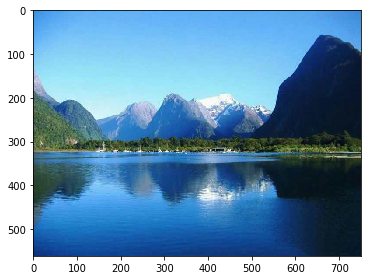

In [28]:
imshow(new_img)

In [29]:
def MSE(img1, img2):
    sum_px = np.sum([(px1 - px2) ** 2 for px1, px2 in zip (img1, img2)])
    mse = np.sqrt(sum_px / (img1.shape[0] * img1.shape[1]))
    return mse


def PSNR(img1, img2):
    return 20 * math.log10(255.0 / math.sqrt(MSE(img1, img2)))


def entropy(img):
    values, _, = np.histogram(img.ravel(), bins=range(257))
    values = values / (img.shape[0] * img.shape[1])
    entropy = -sum(px * np.log2(px) for px in values if px != 0)
    return entropy

In [30]:
PSNR(img, new_img)

39.28864870656484

In [31]:
print(entropy(new_img))
print(entropy(img))

18.7877840739381
18.753227810552335


Вывод: как мы видим, изображение после сжатия восстанавливается хорошо. PSNR исходного и восстановленного изображения равен 39.288, что является довольно хорошим результатом. Число PSNR отражает схожесть между изображениями, однако высокое значение не всегда дает гарантию того, что восстановленное изображение будет приемлимым. Но так как выполняется два пункта выше, то можно сказать, что алгоритм сжатия отработал успешно. При этом, энтропия исходного изображения и восстановленного - отличаются незначительно, что говорит о том, что информация не была упорядочена сильно. 